# Assignment 1
I'll start by including some of the libraries I'll be needing throughout this

In [17]:
using Parameters,Distributions,LinearAlgebra,Plots,Random
default(linewidth=2,legend=false)

#### Problem 1
The following code simulates an MA1 process of length $T$ for arbitrary $\theta$

In [2]:
"""
    simulateMA1(θ,T)

Simulates the MA1 process with lag coefficient θ for T periods
"""
function simulateMA1(θ,T)
    ϵ = randn(T+1) #need to draw t+1 values
    
    return (y=[ϵ[t+1]-θ*ϵ[t] for t in 1:T],ϵ=ϵ) #note ϵ[t] is really ϵ_{t-1}
end;

Simulating 100 periods gives us

In [3]:
y,ϵ = simulateMA1(2,100)
y

100-element Vector{Float64}:
 -3.7698609411994806
  1.0147036311651798
  0.34336796128797625
  0.34487488393793986
  1.3359885934578557
 -1.2261620455871622
 -2.146454789978708
  2.07525836964581
 -1.226044311274958
  1.3728321668060954
  ⋮
 -4.2187354985223795
  1.0733847938877308
 -0.9530897896338306
  1.0448483639850852
  0.7579065908601259
  0.8013266498537407
 -1.6234828305457025
 -1.8065969432575164
 -1.1779002561127154

#### Problem 2

Starting from
$$
y_t = \epsilon_t - \theta\epsilon_{t-1}
$$
we get
\begin{align*}
    \epsilon_t &= y_t + \theta\epsilon_{t-1}\\
            &= y_t +\theta y_{t-1} +\theta^2\epsilon_{t-2}\\
            &\vdots\\
            &=y_t +\theta y_{t-1}+\theta^2y_{t-2} +\ldots+\theta^J y_{t-J}+\theta^{J+1}\epsilon_{t-J-1}. \\
\end{align*}

The coefficients aren't square summable since $\lim_{J\rightarrow\infty}\sum_{j=0}^J\theta^j=\infty$.


Note that if $y_t,y_{t-1},\ldots,y_{t-J}$ are in our information set then $\sum_{j=0}^J\theta^jy_{t-j}$ is an unbiased estimator
of $\epsilon_t$ (since the mean of $\epsilon_{t-J-1}$ is zero).  But the variance of the estimator blows up to infinity with $J$ since 
$\theta^{J+1}\rightarrow\infty$.  If $\theta<1$ then the variance of this estimator would converge to zero.

#### Problem 3
Let $x_t = [\epsilon_t\quad\epsilon_{t-1}]'$ then $x_{t+1} = [\epsilon_{t+1}\quad\epsilon_{t}]'$ and it is clear that 
$$
x_{t+1} = \underbrace{\left(\begin{matrix}0 & 0\\ 1&0\end{matrix}\right)}_A x_t + \underbrace{\left(\begin{matrix}1\\0\end{matrix}\right)}_C\epsilon_{t+1}
$$
and
$$
y_{t} = \underbrace{\left(\begin{matrix}1 & -\theta\end{matrix}\right)}_G x_t
$$
Thus we must also have that $R=0$.

#### Problem 4
First we'll create our KalmanFilter object modified so as to be constructed for an arbitrary $\theta$

In [4]:
@with_kw struct MAKalmanFilter #Not using mutable because I don't ever want to change the values
    #Parameters
    θ::Float64 #Will need to set this parameter to construct the Kalman Fiter
    A::Matrix{Float64} = [0. 0.;
                          1. 0.]
    G::Matrix{Float64} = [1. -θ] #note this is using the value of θ above
    C::Matrix{Float64} = [1.;0][:,:]
    R::Matrix{Float64} = [0.][:,:]

    #Initial Beliefs
    x̂0::Vector{Float64} = [0.;0]
    Σ0::Matrix{Float64} = Matrix{Float64}(I,2,2) #This constructs the identity matrix
end;

Next we have our code from class

In [5]:
"""
    updateBeliefs(KF::KalmanFilter,y,x̂,Σ)

Uses the Kalman Filter to update beliefs x̂,Σ using data y 
"""
function updateBeliefs(KF::MAKalmanFilter,y,x̂,Σ)
    @unpack A,G,C,R = KF
    a = y - G*x̂
    K = A*Σ*G'*inv(G*Σ*G'+R)
    x̂′= A*x̂ + K*a
    Σ′ = C*C' + K*R*K' + (A-K*G)*Σ*(A' - G'*K')
    
    return x̂′,Σ′
end

"""
    applyFilter(KF::KalmanFilter,y)

Applies the Kalman Filter on data y. Assume y is mxT where 
T is the number of periods
"""
function applyFilter(KF::MAKalmanFilter,y)
    @unpack x̂0,Σ0 = KF

    T = size(y,2) #how many rows are y
    x̂ = zeros(length(x̂0),T+1)
    Σ = zeros(length(x̂0),length(x̂0),T+1)
    x̂[:,1] .= x̂0
    Σ[:,:,1] .= Σ0
    for t in 1:T
        x̂[:,t+1],Σ[:,:,t+1] = updateBeliefs(KF,y[:,t],x̂[:,t],Σ[:,:,t])
    end

    return x̂,Σ
end

applyFilter

Finally we can apply our kalman filter given an arbitrary $\theta$

In [6]:
kf = MAKalmanFilter(θ=5)
kf.G

1×2 Matrix{Float64}:
 1.0  -5.0

In [7]:
"""
    applyFilterMA(y,θ)

Applys the filter to data y given parameter θ
"""
function applyFilterMA(y::Vector{Float64},θ::Float64)
    kf = MAKalmanFilter(θ=θ)#construct KalmanFilter object with parameter θ
    return applyFilter(kf,y')
end

applyFilterMA

We can verify how this works by plotting the true state $\epsilon_t$
versus the filtered value

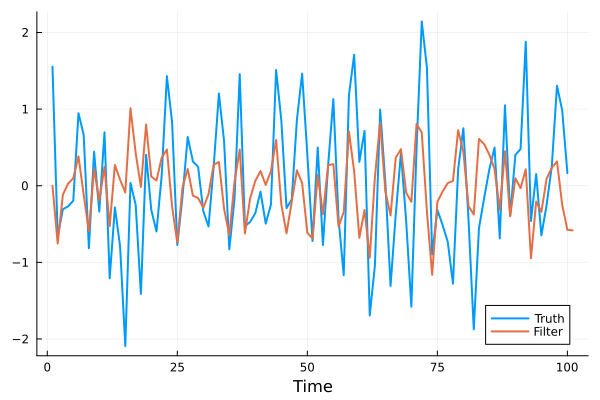

In [9]:
x̂,Σ = applyFilterMA(y,2.)
plot(ϵ[1:end-1],label="Truth",legend=true)
plot!(x̂[2,:],label="Filter",xlabel="Time")

#### Problem 5
Next we want to compute the log likelihood.  For that we'll need the pdf of
the normal distribution so we'll use the distributions package

In [10]:
"""
    get_loglikelihood(y,θ)

Constructs the log likelihood for a given parameter θ
"""
function get_loglikelihood(y,θ)
    T = length(y)
    kf = MAKalmanFilter(θ=θ)
    x̂,Σ = applyFilterMA(y,θ)
    logl = 0.
    for t in 1:T
        Gx̂ = (kf.G*x̂[:,t])[1] #make it a float for normal distribution
        Ω = (kf.G*Σ[:,:,t]*kf.G' + kf.R)[1]
        logf = log(pdf(Normal(Gx̂,sqrt(Ω)),y[t]))
        logl += logf
    end

    return logl
end

get_loglikelihood

#### Problem 6
Let's plot this log likelihood as a function of $\theta$.  Plotting over a
range of (-4,4) we see

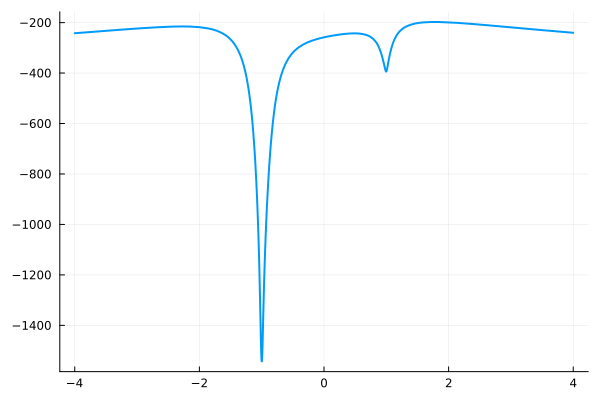

In [11]:
plot(θ->get_loglikelihood(y,θ),-4.,4)

It's not super clear where this maximation occurs so let's split up the range into $(-\infty,1.5)$,$(-0.8,0.8)$ and $(1.5,\infty)$.

Creating those plots we get

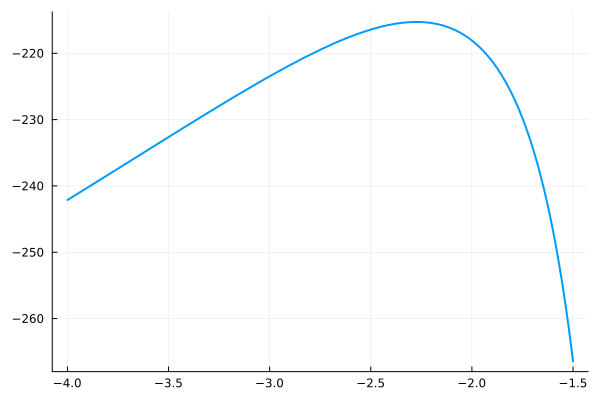

In [12]:
plot(θ->get_loglikelihood(y,θ),-4.,-1.5)

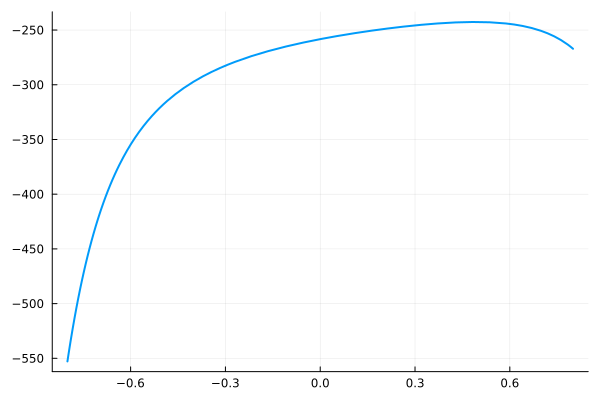

In [13]:
plot(θ->get_loglikelihood(y,θ),-0.8,0.8)

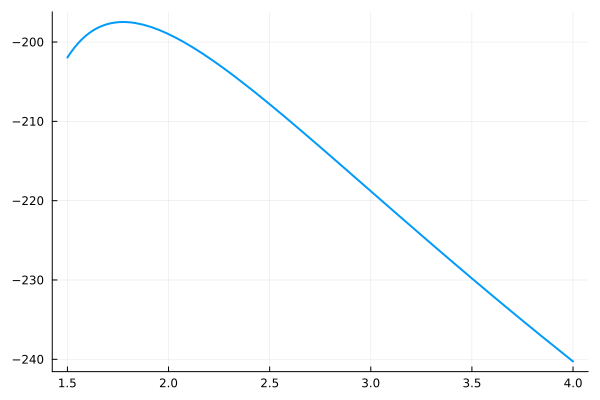

In [14]:
plot(θ->get_loglikelihood(y,θ),1.5,4.)

The log likelihood is maximized around 2.

We can delve deeper by constructing a grid on $\theta$

In [15]:
θrange = LinRange(1.2,3.,100)
logl = [get_loglikelihood(y,θ) for θ in θrange]
logmax,imax = findmax(logl)
println("The maximized likelihood is $logmax at θ=$(θrange[imax])")

The maximized likelihood is -197.47670663595605 at θ=1.7818181818181817


Finally we can see what happens as we change the number of data points.
I'll use pseudo random numbers so that the data series of length 100 is
nested within the dataseries of length 1000.

In [18]:
Random.seed!(45634)
y = simulateMA1(2,100).y
logl_100 = [get_loglikelihood(y,θ) for θ in θrange]
logl_100max = maximum(logl_100)
Random.seed!(45634)
y = simulateMA1(2,1000).y
logl_1000 = [get_loglikelihood(y,θ) for θ in θrange]
logl_1000max = maximum(logl_1000)

-2103.5587608354385

Plotting the likelihood relative to the maximum likelihood we get

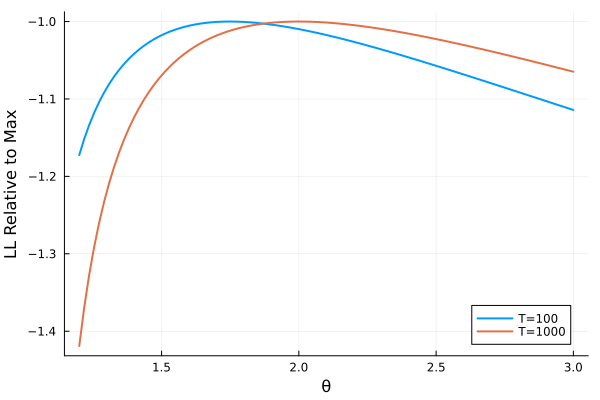

In [19]:
plot(θrange,logl_100./abs(logl_100max),label="T=100",legend=true)
plot!(θrange,logl_1000./abs(logl_1000max),label="T=1000",xlabel="θ",ylabel="LL Relative to Max")

We can see that $T=1000$ provides a tighter estimate and more accurate estimate!

#### Problem 6

Let's run the Kalman Filter for $\theta=2$ and $\theta =0.5$

In [20]:
y = simulateMA1(2.,100).y
x̂,Σhigh = applyFilterMA(y,2.)

y = simulateMA1(0.5,100).y
x̂,Σlow = applyFilterMA(y,0.5)

([0.0 0.0 … 0.0 0.0; 0.0 -0.3419687779591547 … -0.8883117294147902 -0.7952840101681987], [1.0 0.0; 0.0 1.0;;; 1.0 0.0; 0.0 0.2;;; 1.0 0.0; 0.0 0.047619047619047616;;; … ;;; 1.0 0.0; 0.0 7.467618333433369e-60;;; 1.0 0.0; 0.0 1.8669045833583422e-60;;; 1.0 0.0; 0.0 4.6672614583958556e-61])

Plotting the standard deviation for second component we get

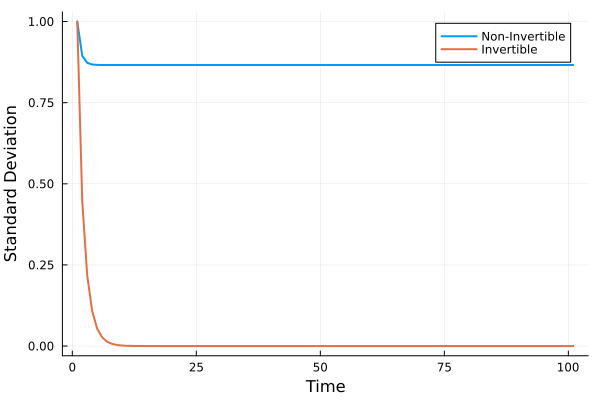

In [22]:
plot(sqrt.(Σhigh[2,2,:]),label="Non-Invertible",legend=true)
plot!(sqrt.(Σlow[2,2,:]),label="Invertible",xlabel="Time",ylabel="Standard Deviation")

When $|\theta|<1$ we filter out the state $\epsilon_t$.